# Setup

In [1]:
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
import torch

from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [3]:
work_dir = "/home/spaka002/NSF_REU_2024/"
data_folder = f"{work_dir}classification_datasets/"

# Some Functions

In [4]:
def save_tensor(tensor, save_path):
    torch.save(tensor.clone().detach(), save_path)
    print(f"\nSuccessfully saved tensor to \n{save_path}\n")

In [5]:
def train_block(clf, opt, loss_fn, X_train, Y_train, num_epochs = 10, batch_size = 128):

    train = list()
    for i in range(len(X_train)):
        train.append((X_train[i], Y_train[i]))

    trainloader = DataLoader(train, batch_size)

    for epoch in range(1, num_epochs+1):

        for batch in trainloader:

            x,y = batch 
            Yhat = clf(x)

            loss = loss_fn(Yhat, y)

            #backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()    
    
    return clf

In [6]:
def return_eval(model, x, y, n_splits, opt, loss_fn, num_epochs=10, batch_size=128, smote_train=False):

    kf = KFold(n_splits=n_splits, shuffle = True, random_state = 18)
    kf.get_n_splits(x)

    overall_metric = 0
    for i, (train_index, test_index) in enumerate(kf.split(x)):

        X_train = x[train_index]
        X_test = x[test_index]

        Y_train = y[train_index]
        Y_test = y[test_index]

        if (smote_train):
            smote = SMOTE(random_state=18)
            X_train, Y_train = smote.fit_resample(X_train, Y_train)


        model = train_block(clf = model,
                            opt = opt,
                            loss_fn = loss_fn, 
                            X_train = X_train,
                            Y_train = Y_train, 
                            num_epochs = num_epochs,
                            batch_size = batch_size)
        
        
        preds = model(X_test).cpu().detach().numpy()
        
        pred_labels = torch.tensor([x.argmax() for x in preds], dtype = torch.long)
        
        # _______ insert evaluation metric ___________________________________
        
        if (len(set(y)) == 2): average = 'binary'
        else: average = 'weighted'
            
        metric_value = f1_score(Y_test.cpu(), pred_labels.cpu(), average = average)
        
        # ____________________________________________________________________
        
        overall_metric += metric_value
            
    return (overall_metric/n_splits)

In [7]:
def convert_categorical(df):

    num_c = len(list(df.columns))
    
    for c in range(num_c):
        
        if (type(data.iloc[:, c][0]) != str): continue

        vals = list(set(df.iloc[:, c]))

        t_d = dict()

        for v in range(len(vals)):
            val = vals[v]
            t_d[val] = v

        df.iloc[:, c] = df.iloc[:, c].map(lambda x: t_d[x])
        
    return df

# Get Data

In [8]:
# data = pd.read_csv(f"{data_folder}car.data", names = [f"Feature_{i}" for i in range(1, 7)] + ['Target'])
# data = np.array(convert_categorical(data), dtype = np.int8)

# X = torch.tensor(data[:, :-1], dtype = torch.float32)
# Y = torch.tensor(data[:, -1], dtype = torch.long)

# del data

In [9]:
# undersample_amt = 15000

# data = pd.read_excel(f"{data_folder}default_creditcard.xls")
# data = data.iloc[1:, 1:]

# indices = list(data[data['Y'] == 0].index)
# random.Random(18).shuffle(indices)

# negatives = np.array(data.iloc[indices[:undersample_amt]])
# positives = np.array(data[data['Y'] == 1])

# dataset = np.concatenate((positives, negatives), axis = 0)
# data_names = list(data.columns)

# del data, negatives, positives

# X = np.array(dataset[:, :-1], dtype = np.float32)
# Y = np.array(dataset[:, -1], dtype = np.uint8)

# del dataset

In [10]:
data = np.load(f"{data_folder}MiniBoone_Particle_ID.npy")

X = data[:, :-1]
Y = data[:, -1]

del data

In [11]:
# undersample_amt = 35346

# data = pd.read_csv(f"{data_folder}diabetes_binary.csv")

# negative_indices = list(data[data['Diabetes_binary'] == 0].index)
# random.Random(18).shuffle(negative_indices)

# negatives = np.array(data.iloc[negative_indices[:undersample_amt]])
# positives = np.array(data[data['Diabetes_binary'] == 1])

# dataset = np.concatenate((positives, negatives), axis = 0)
# data_names = list(data.columns)

# del data, negatives, positives, negative_indices

# X = np.array(dataset[:, 1:])
# Y = np.array(dataset[:, 0])

# del dataset

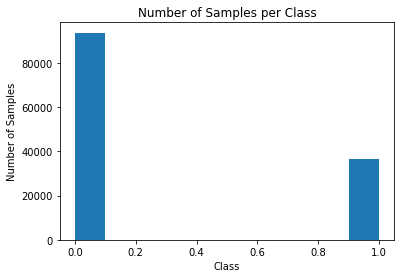

In [12]:
plt.hist(Y)
plt.title("Number of Samples per Class")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [13]:
print(f"X Shape: {X.shape}; Y Shape: {Y.shape}")

X Shape: (130064, 50); Y Shape: (130064,)


In [14]:
def get_subset(x, y, portion=1, random_state=18):
    
    if (portion>=1): return x, y
    
    X, tx, Y, ty = train_test_split(x, y, test_size=(1-portion), random_state=random_state)
    del tx, ty
    
    return X, Y

In [15]:
X, Y = get_subset(X, Y, 
                  portion=0.1, 
                  random_state=18)

X, Y = torch.tensor(X, dtype = torch.float32).to(device), torch.tensor(Y, dtype = torch.long).to(device)

In [16]:
print(f"X Shape: {X.shape}; Y Shape: {Y.shape}")

X Shape: torch.Size([13006, 50]); Y Shape: torch.Size([13006])


# Deep Learning Model

In [17]:
class NN_clf(nn.Module):
    def __init__(self, input_dim, hidden_dim = 100, num_fc = 2, act = 'relu', dropout_p = 0.1, num_classes = 2):
        super(NN_clf, self).__init__()
        
        self.num_fc = num_fc

        self.in_ = nn.Linear(input_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        
        self.dropout = nn.Dropout(p=dropout_p)
        
        if (act == 'relu'):
            self.act = nn.ReLU()
            
        elif (act == 'tanh'):
            self.act = nn.Tanh()
            
        elif (act == 'sigmoid'):
            self.act = nn.Sigmoid()
        
        self.out_ = nn.Linear(hidden_dim, num_classes)
        
        
    def forward(self, x):
        
        x = self.in_(x)
        
        for i in range(self.num_fc):
            x = self.fc(x)
            x = self.act(x)
            x = self.dropout(x)
            
        x = self.out_(x)
        
        return x

# Test Model

In [18]:
run_test = False

if (run_test):
    
    num_classes = len(set(Y))

    classifier = NN_clf(input_dim = int(X.shape[1]),
                                    hidden_dim = 100,                  # can change hidden_dim
                                    num_fc = 5,                        # can change number of layers
                                    act = 'relu',                      # can change activation function
                                    dropout_p = 0.0,                   # can change dropout probability
                                    num_classes = num_classes
                                   ).to(device)

    opt = Adam(classifier.parameters(), lr=5e-3)                    # can change optimizer
                                                                    # can change learning rate

    loss_fn = nn.CrossEntropyLoss()                                 # can change loss function

    result = return_eval(model = classifier, 
                         x = X, 
                         y = Y, 
                         n_splits = 3, 
                         opt = opt, 
                         loss_fn = loss_fn, 
                         num_epochs=25,                   # can change num_epochs
                         batch_size=128,                  # can change batch_size
                         smote_train=False)               # can change SMOTE


    print(result)

# Generate Tensor

In [19]:
dim5=['relu']
dim4=list(range(1, 15+1, 2))
dim3=list(range(5, 50+1, 5))
dim2=[10, 25, 50, 100, 250, 500]
dim1=[128, 256, 512, 1024]

total_cells = len(dim1)*len(dim2)*len(dim3)*len(dim4)*len(dim5)

print(f"({len(dim5)}x{len(dim4)}x{len(dim3)}x{len(dim2)}x{len(dim1)}) tensor output.\n")
print(f" {total_cells} total combinations.")

(1x8x10x6x4) tensor output.

 1920 total combinations.


In [20]:
i = 0
num_classes = len(set(Y))

tensor_5 = list()
for act in dim5:

    tensor_4 = list()
    for num_fc in dim4:

        tensor_3 = list()
        for num_epochs in dim3:

            tensor_2 = list()
            for hidden_dim in dim2:

                tensor_1 = list()
                for batch_size in dim1:

                    classifier = NN_clf(input_dim = int(X.shape[1]),
                                        hidden_dim = hidden_dim,                  # can change hidden_dim
                                        num_fc = num_fc,                          # can change number of layers
                                        act = act,                                # can change activation function
                                        dropout_p=0.0,
                                        num_classes = num_classes
                                    ).to(device)

                    opt = Adam(classifier.parameters(), lr=5e-3)                  # can change optimizer & learning rate

                    loss_fn = nn.CrossEntropyLoss()                               # can change loss function

                    result = return_eval(model = classifier, 
                                        x = X, 
                                        y = Y, 
                                        n_splits = 3, 
                                        opt = opt, 
                                        loss_fn = loss_fn, 
                                        num_epochs=num_epochs,                   # can change num_epochs
                                        batch_size=batch_size,                   # can change batch_size
                                        smote_train=False)                       # can change SMOTE

                    i+=1
                    if (i%1==0): print(f"{i}/{total_cells} combinations done.")

                    tensor_1+= [result]

                tensor_2+= [tensor_1]

            tensor_3+= [tensor_2]

        tensor_4+= [tensor_3]

    print(f"\n{len(tensor_5)}/{len(dim5)} 4th order tensors done.\n")

tensor = torch.tensor(tensor_5).squeeze()

1/1920 combinations done.
2/1920 combinations done.
3/1920 combinations done.
4/1920 combinations done.
5/1920 combinations done.
6/1920 combinations done.
7/1920 combinations done.
8/1920 combinations done.


KeyboardInterrupt: 

In [ ]:
tensor = torch.tensor(tensor_4)

In [ ]:
tensor.shape

torch.Size([8, 10, 8, 6])

In [ ]:
print(np.round(tensor, 4))

tensor([[[[0.0042, 0.0000, 0.0000, 0.0000, 0.0000, 0.0212],
          [0.0218, 0.0077, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0670, 0.0022, 0.0000, 0.2633, 0.0206, 0.0861],
          ...,
          [0.5777, 0.6279, 0.5995, 0.6182, 0.6328, 0.5852],
          [0.6226, 0.6284, 0.6150, 0.6272, 0.6145, 0.6030],
          [0.4138, 0.5716, 0.5896, 0.5088, 0.4477, 0.4493]],

         [[0.0659, 0.0000, 0.0000, 0.0136, 0.0000, 0.0000],
          [0.0000, 0.0226, 0.1479, 0.1452, 0.0876, 0.0000],
          [0.4656, 0.4313, 0.1711, 0.1166, 0.0333, 0.2443],
          ...,
          [0.5896, 0.5896, 0.6148, 0.5896, 0.5896, 0.5896],
          [0.6320, 0.5875, 0.6488, 0.6457, 0.6121, 0.6007],
          [0.5896, 0.5720, 0.6084, 0.5657, 0.5777, 0.5896]],

         [[0.0000, 0.2764, 0.0000, 0.0000, 0.0066, 0.2294],
          [0.1031, 0.0000, 0.0000, 0.0000, 0.0226, 0.0564],
          [0.2303, 0.4263, 0.5049, 0.3778, 0.4941, 0.3371],
          ...,
          [0.5533, 0.5268, 0.5547, 0.5438, 0.5562, 

In [ ]:
if (False):
    save_tensor(tensor,
                save_path = f"{work_dir}meta_datasets/FCNN_car_evaluation_719.pt")


Successfully saved tensor to 
/home/spaka002/NSF_REU_2024/meta_datasets/FCNN_car_evaluation_719.pt

